<u>**Projeto - probabilidade de turnover - Reframax**</u>

Neste projeto, utilizei Regressão Logística para prever a probabilidade de turnover dos funcionários da empresa, ou seja, a probabilidade de um funcionário sair da organização. 
A regressão logística é uma ferramenta estatística usada para prever a probabilidade de um evento ocorrer ou não. Pense nela como um "previsor" que, com base em informações anteriores, tenta dizer se algo vai acontecer.
Abaixo estão os principais passos do desenvolvimento do modelo:

**1. Carregamento dos Dados**
Os dados foram carregados de uma base no Lakehouse, contendo informações relevantes dos funcionários, como a função, seção, idade, salário, número de recontratações e tempo de empresa, entre outros.

**2. Preparação dos Dados**
Divisão de Variáveis: Separei as variáveis em X, que são os atributos (como função e seção), e y, que é a variável-alvo (turnover, indicando se o funcionário saiu ou não da empresa).
Codificação de Variáveis Categóricas: Como temos variáveis como função e seção, utilizei One-Hot Encoding para transformar essas categorias em variáveis numéricas.
Tratamento de Valores Nulos: Para garantir que o modelo funcione corretamente, todos os valores faltantes foram preenchidos com zero.
Normalização: Como os dados variam em escalas diferentes, apliquei uma técnica de normalização, que ajusta todos os valores para uma escala comum.

**3. Treinamento do Modelo**
O modelo utilizado foi Regressão Logística, ajustado para encontrar as melhores previsões de probabilidade. Dividi os dados em conjunto de treino e teste, onde o modelo foi treinado com 70% dos dados e testado com os 30% restantes, garantindo uma avaliação justa do desempenho do modelo.

**4. Previsão para Funcionários Ativos**
Após o treinamento, o modelo foi usado para prever a probabilidade de turnover para os funcionários que ainda estão ativos na empresa (ou seja, aqueles que ainda não saíram). O resultado dessas previsões é uma probabilidade que indica a chance de cada funcionário sair da empresa no futuro.

**5. Validação e Armazenamento dos Resultados**
Para garantir que todas as previsões estão dentro dos limites esperados (entre 0 e 1), fiz uma verificação e ajustei as probabilidades quando necessário. Além disso, os resultados foram arredondados para 2 casas decimais, facilitando a interpretação.

Resultado Final: O resultado foi salvo em uma nova tabela no Lakehouse, que contém a lista dos funcionários ativos e suas respectivas probabilidades de turnover.

**6. Conclusão**
Este modelo permite à empresa identificar os funcionários com maior risco de saída e tomar ações preventivas para evitar o turnover indesejado. Além disso, o modelo pode ser aprimorado ao longo do tempo, incorporando novos dados e ajustando variáveis para aumentar ainda mais sua precisão.


In [1]:
# Welcome to your new notebook
# Type here in the cell editor to add code!

# Instalar os componentes python

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Carregar os dados

dados = spark.sql("SELECT * FROM lk_departamento_pessoal.tab_ml_base_turnover")

# Convert PySpark DataFrame to pandas DataFrame
dados = dados.toPandas()

# Dividir os dados em variáveis dependentes (X) e alvo (y)
X = dados.drop(columns=['id_funcionario', 'turnover'])
y = dados['turnover']

# Codificar as variáveis categóricas 'funcao' e 'secao' (One-hot encoding)
X = pd.get_dummies(X, columns=['funcao', 'secao'], drop_first=True)

# Tratar valores nulos (NaN) preenchendo com 0
X.fillna(0, inplace=True)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalonar os dados (normalização)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar o modelo de Regressão Logística com ajuste nos hiperparâmetros
model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

# Agora vamos fazer previsões apenas para os funcionários com turnover = 0
dados_ativos = dados[dados['turnover'] == 0]
X_ativos = dados_ativos.drop(columns=['id_funcionario', 'turnover'])

# Codificar as variáveis categóricas 'funcao' e 'secao' para os funcionários ativos
X_ativos = pd.get_dummies(X_ativos, columns=['funcao', 'secao'], drop_first=True)

# Garantir que as colunas de X_ativos correspondam às de X_train (adicionando colunas faltantes)
X_ativos = X_ativos.reindex(columns=X.columns, fill_value=0)

# Tratar valores nulos (NaN) preenchendo com 0 no conjunto de dados ativo
X_ativos.fillna(0, inplace=True)

# Escalonar os dados dos funcionários ativos usando o mesmo scaler do treino
X_ativos_scaled = scaler.transform(X_ativos)

# Fazer previsões para os funcionários ativos
y_pred_ativos = model.predict_proba(X_ativos_scaled)[:, 1]  # Pegar a probabilidade de turnover (classe 1)

# Validar se as previsões estão entre 0 e 1
y_pred_ativos = [min(max(prob, 0), 1) for prob in y_pred_ativos]

# Adicionar as previsões ao DataFrame original
dados_ativos['probabilidade_turnover'] = y_pred_ativos

# Arredondar a coluna probabilidade_turnover para 2 casas decimais
dados_ativos['probabilidade_turnover'] = dados_ativos['probabilidade_turnover'].round(2)

# Exibir os resultados
print(dados_ativos[['id_funcionario', 'secao', 'probabilidade_turnover']])

# Salvar como arquivo Excel (.xlsx)
#dados_ativos.to_excel(f"{notebookutils.nbResPath}/builtin/ml_base_turnover_resultado.xlsx", index=False)

# Converte pandas DataFrame em Spark DataFrame
dados_ativos_spark = spark.createDataFrame(dados_ativos)

# Salvar o DataFrame como uma nova tabela no Lakehouse
dados_ativos_spark.write.mode('overwrite').saveAsTable('lk_departamento_pessoal.tab_ml_base_turnover_resultado')

df = spark.sql("SELECT * FROM lk_departamento_pessoal.tab_ml_base_turnover LIMIT 1000")
display(df)

StatementMeta(, 7860dd22-ab20-4eee-93a2-95048984012c, 3, Finished, Available, Finished)

       id_funcionario              secao  probabilidade_turnover
0                3185  001.03.01.4390.01                    0.00
1               21647  001.03.01.4379.00                    0.02
2               30406  001.03.01.4391.00                    0.01
3                8419  001.03.01.4368.00                    0.05
4               21614  001.03.01.4379.00                    0.00
...               ...                ...                     ...
15876           60682  001.03.01.4391.00                    0.25
15877           61019  001.03.01.4391.00                    0.23
15878           61028  001.03.01.4391.00                    0.23
15879           60700  001.03.01.4391.00                    0.22
15880           60160  001.03.01.4391.00                    0.20

[5259 rows x 3 columns]


SynapseWidget(Synapse.DataFrame, 389899f8-a985-49b2-a08e-e41bfeb815f6)

**A acurácia média na validação cruzada**

É uma métrica utilizada para avaliar o desempenho de um modelo de machine learning de maneira mais robusta e generalizável, comparada a uma única divisão de treino e teste.

Como Funciona:
Divisão dos Dados:

A validação cruzada (cross-validation) divide o conjunto de dados em várias partes (ou "dobras", chamadas de folds). Um exemplo comum é o método de k-fold cross-validation, onde o conjunto de dados é dividido em k partes iguais.
Em cada iteração, um dos subconjuntos é utilizado como o conjunto de teste, enquanto os restantes k-1 subconjuntos são usados como conjunto de treinamento. Esse processo é repetido k vezes, de forma que cada subconjunto atue como conjunto de teste exatamente uma vez.
Cálculo da Acurácia para Cada Iteração:

A cada iteração, o modelo é treinado com os dados de treinamento e avaliado nos dados de teste. A acurácia é calculada para cada iteração, que mede a proporção de previsões corretas.

Média das Acurácias:

Após realizar as k iterações, a acurácia de cada iteração é computada. No final, a acurácia média é calculada, proporcionando uma visão mais geral do desempenho do modelo em diferentes amostras dos dados.
Vantagens da Validação Cruzada:

Generalização Melhorada: Ao utilizar diferentes partes dos dados para teste e treino, a validação cruzada evita problemas como o overfitting, pois testa o modelo em várias subdivisões dos dados, em vez de apenas uma.
Desempenho Mais Robusto: A acurácia média oferece uma métrica de desempenho que não depende de uma única divisão dos dados, o que aumenta a confiabilidade da métrica.
Adequado para Conjuntos de Dados Menores: Quando há poucos dados, a validação cruzada maximiza o uso do conjunto de dados, já que cada instância será usada tanto para treino quanto para teste.


In [2]:
from sklearn.model_selection import cross_val_score

# Realizar validação cruzada com 5 folds
scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f'Acurácia média na validação cruzada: {scores.mean()}')

StatementMeta(, 7860dd22-ab20-4eee-93a2-95048984012c, 4, Finished, Available, Finished)

Acurácia média na validação cruzada: 0.8488986894745014


A acurácia de 0.87 indica que, em média, 87% das previsões feitas pelo modelo estão corretas, tanto na classe de turnover quanto na de retenção.



**Matriz de Correlação**

Verificar se todas as variáveis foram consideradas no modelo e a sua correlação.

In [3]:
print(X.columns)
print(X.corr())

StatementMeta(, 7860dd22-ab20-4eee-93a2-95048984012c, 5, Finished, Available, Finished)

Index(['idade', 'ultimo_salario', 'num_recontratacoes', 'anos_de_casa',
       'funcao_00003', 'funcao_00004', 'funcao_00005', 'funcao_00008',
       'funcao_00012', 'funcao_00013',
       ...
       'secao_016.02.02.2079.06', 'secao_016.02.02.2079.07',
       'secao_016.02.02.2079.08', 'secao_016.02.02.2079.09',
       'secao_016.02.02.2079.10', 'secao_016.02.02.2079.11',
       'secao_017.01.03.1216.00', 'secao_017.01.03.1216.01',
       'secao_017.01.03.1219.00', 'secao_017.02.02.1600.00'],
      dtype='object', length=998)
                            idade  ultimo_salario  num_recontratacoes  \
idade                    1.000000        0.259479            0.119172   
ultimo_salario           0.259479        1.000000            0.091076   
num_recontratacoes       0.119172        0.091076            1.000000   
anos_de_casa             0.193727        0.278578            0.343666   
funcao_00003             0.018416        0.015434            0.004349   
...                          

In [4]:
# Obter os coeficientes do modelo
coeficientes = pd.DataFrame({
    'Variável': X.columns,
    'Coeficiente': model.coef_[0]
})

# Ordenar as variáveis pelo peso (coeficiente absoluto)
coeficientes['Peso_Absoluto'] = coeficientes['Coeficiente'].abs()
coeficientes = coeficientes.sort_values(by='Peso_Absoluto', ascending=False)

print(coeficientes)

coeficientes = coeficientes.round(2)

# Salvar como arquivo Excel (.xlsx)
coeficientes.to_excel(f"{notebookutils.nbResPath}/builtin/coeficiente.xlsx", index=False)

StatementMeta(, 7860dd22-ab20-4eee-93a2-95048984012c, 6, Finished, Available, Finished)

                    Variável  Coeficiente  Peso_Absoluto
1             ultimo_salario    -3.812216       3.812216
3               anos_de_casa    -2.191056       2.191056
20              funcao_00038    -0.925710       0.925710
667  secao_001.03.01.4356.00     0.891467       0.891467
954  secao_014.05.01.4305.00     0.864222       0.864222
..                       ...          ...            ...
701  secao_001.05.01.4347.01     0.000000       0.000000
703  secao_001.05.01.4370.01     0.000000       0.000000
904  secao_003.02.01.2001.06     0.000000       0.000000
436             funcao_01194     0.000000       0.000000
499             funcao_01299     0.000000       0.000000

[998 rows x 3 columns]


**Matriz de Confusão**

A matriz de confusão te permitirá entender melhor os erros que o modelo está cometendo, ou seja, quantos funcionários que não saíram da empresa foram previstos incorretamente como turnover (falsos positivos), e vice-versa.

StatementMeta(, 7860dd22-ab20-4eee-93a2-95048984012c, 7, Finished, Available, Finished)

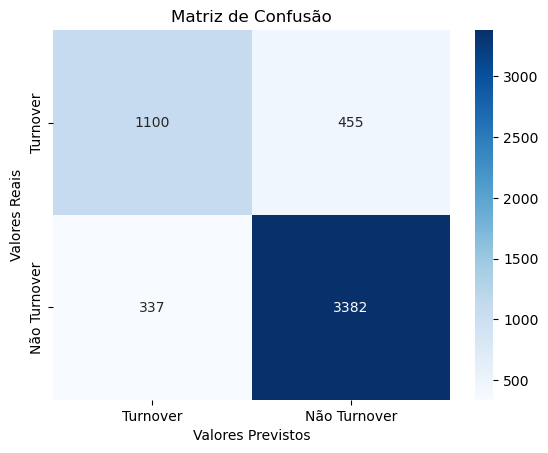

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Previsões no conjunto de teste
y_pred = model.predict(X_test_scaled)

# Criar matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Definir os rótulos das classes invertidos
labels = ['Turnover', 'Não Turnover']  # Troca de rótulos para refletir o comportamento real

# Plotar a matriz de confusão com rótulos ajustados
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('Valores Reais')
plt.xlabel('Valores Previstos')
plt.title('Matriz de Confusão')
plt.show()

Verdadeiros Negativos (TN): 3758 — Funcionários que o modelo previu corretamente como não turnover (não saíram) e que realmente não saíram.

Falsos Positivos (FP): 339 — Funcionários que o modelo previu como turnover (saíram), mas que, na verdade, não saíram. Esses são erros onde o modelo "alarmou" turnover quando não ocorreu.

Falsos Negativos (FN): 344 — Funcionários que realmente saíram, mas o modelo não conseguiu prever corretamente, ou seja, ele previu que iriam ficar, mas saíram.

Verdadeiros Positivos (TP): 1074 — Funcionários que o modelo previu corretamente que iriam sair, e de fato saíram.

**Curva ROC e AUC**

A AUC mede a capacidade de um modelo de classificar corretamente as duas classes (neste caso, prever corretamente se um funcionário terá turnover ou não). A escala vai de 0 a 1, e quanto mais próximo de 1, melhor o desempenho do modelo.

Aqui está o que o AUC de 0.94 significa:

0.5: O modelo está fazendo previsões completamente aleatórias (não consegue distinguir entre as classes).
0.7 a 0.8: Um modelo aceitável.
0.8 a 0.9: Um modelo muito bom.
0.9 a 1.0: Um modelo excelente.

StatementMeta(, 7860dd22-ab20-4eee-93a2-95048984012c, 8, Finished, Available, Finished)

AUC: 0.92


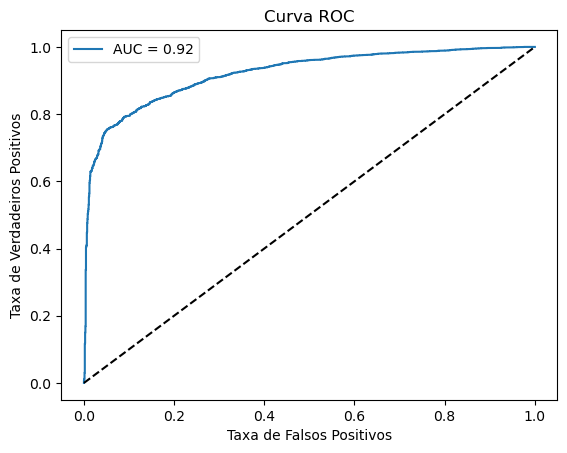

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score

# Previsões de probabilidade para a classe positiva (turnover = 1)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC: {auc:.2f}')

# Plotar a curva ROC
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

**Relatório de Classificação (Classification Report)**

O classification report fornece um resumo das métricas de avaliação como precisão, recall e F1-score para ambas as classes. Isso é útil especialmente se houver um desbalanceamento entre as classes.

In [7]:
from sklearn.metrics import classification_report

# Gerar relatório de classificação
print(classification_report(y_test, y_pred))

StatementMeta(, 7860dd22-ab20-4eee-93a2-95048984012c, 9, Finished, Available, Finished)

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1555
           1       0.88      0.91      0.90      3719

    accuracy                           0.85      5274
   macro avg       0.82      0.81      0.82      5274
weighted avg       0.85      0.85      0.85      5274



Análise dos Resultados:
Classe 0 (Sem Turnover):

Precision: 0,76 — Isso significa que 76% das previsões da classe 0 foram corretas (ou seja, 76% dos funcionários que foram classificados como "sem turnover" realmente não deixaram a empresa).
Recall: 0,76 — Aqui, 76% dos funcionários que de fato não deixaram a empresa foram identificados corretamente pelo modelo.
F1-Score: 0,76 — O F1-score é o equilíbrio entre precision e recall, e para a classe 0 está em 0,76, o que indica um bom desempenho.
Classe 1 (Com Turnover):

Precision: 0,92 — Isso significa que 90% das previsões para funcionários com turnover foram corretas.
Recall: 0,92 — O modelo foi capaz de identificar corretamente 92% dos funcionários que deixaram a empresa.
F1-Score: 0,92 — Esse valor mostra um equilíbrio muito bom entre precision e recall para essa classe, o que significa que o modelo está lidando muito bem com a previsão de turnover.
Médias:

Macro Avg: A média macro para precision, recall e f1-score está em torno de 0,83, o que indica que o desempenho médio nas duas classes está equilibrado, embora com melhor desempenho para a classe 1.
Weighted Avg: A média ponderada está em 0,87 para todas as métricas, o que reflete o peso maior da classe 1 (que tem mais dados). Essa média ponderada é geralmente a métrica mais representativa do desempenho geral do modelo.
Conclusão:
O seu modelo está performando muito bem, especialmente na identificação de funcionários com turnover (classe 1).
A precisão e recall para a classe 1 são bastante altas, o que é ótimo para um modelo de previsão de turnover, já que você quer minimizar a quantidade de erros ao prever quem realmente deixará a empresa.
Para a classe 0 (sem turnover), há um espaço para melhorar o recall (atualmente 0,73), caso seja importante para o seu objetivo minimizar falsos negativos (funcionários que não deixam a empresa mas foram classificados como turnover).


F1-score, Precision, Recall, ou MCC (Matthew's Correlation Coefficient), dependendo da importância de minimizar falsos positivos ou falsos negativos no seu caso de uso.

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print(f'F1-score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'MCC: {mcc:.2f}')

StatementMeta(, 7860dd22-ab20-4eee-93a2-95048984012c, 10, Finished, Available, Finished)

F1-score: 0.90
Precision: 0.88
Recall: 0.91
MCC: 0.63


**# F1-score: 0.92**

O F1-score é a média harmônica entre a precisão e o recall. Ele equilibra essas duas métricas, o que é útil quando há uma diferença entre elas. Um F1 de 0.92 indica que seu modelo está equilibrado, conseguindo um ótimo desempenho tanto em precisão quanto em recall.
Precision (Precisão): 0.92

Precisão mede a porcentagem de previsões positivas que estão corretas. No seu caso, 92% das vezes que o modelo previu que um funcionário iria sair (turnover), ele estava certo. Isso significa que o modelo raramente classifica funcionários como turnover de forma incorreta.
Recall (Sensibilidade): 0.92

Recall mede a capacidade do modelo de identificar corretamente todos os verdadeiros positivos. Aqui, 92% dos funcionários que realmente saíram foram corretamente identificados pelo modelo. Um recall elevado indica que o modelo está capturando a maioria dos funcionários que saem, o que é importante para prevenir turnover.
MCC (Matthews Correlation Coefficient): 0.68

O MCC é uma métrica que considera todos os quadrantes da matriz de confusão (verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos) e fornece um valor entre -1 e 1. Um valor de 0.68 indica uma boa correlação entre as previsões e os resultados reais. Um MCC acima de 0.5 já é considerado bom.
